# Stock Market Prediction Project

This notebook focuses on predicting the S&P 500 index movements using machine learning techniques. We will leverage historical stock data, perform exploratory data analysis (EDA), engineer useful features (such as technical indicators), and build classification models to predict whether the stock market will go up or down on the next day.

**Objective:**

The goal of this project is to use financial data, specifically the S&P 500 index, to build predictive models that can classify future stock movements (upward or downward) based on historical trends and technical indicators. We will evaluate several machine learning algorithms to determine which model performs best in this context.

In [1]:
# Imports for the entire project

# Data Handling and Visualization
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Machine Learning and Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Suppress warnings from pandas for cleaner outputs
import warnings
warnings.filterwarnings('ignore')

## 1. Data Acquisition

We will use the `yfinance` library to download historical financial data for the S&P 500 index. The data will range from January 20, 2003, to today's date.


In [2]:
# Get today's date for the end date
today = datetime.today().strftime('%Y-%m-%d')

# Download S&P 500 historical data from 2003 to today
sp500 = yf.download('^GSPC', start='2003-01-20', end=today)

# Display the first few rows to verify the data
print("First five rows of the S&P 500 data:")
print(sp500.head())

# Display summary statistics for the dataset
print("\nSummary statistics of the S&P 500 data:")
print(sp500.describe())


[*********************100%***********************]  1 of 1 completed

First five rows of the S&P 500 data:
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2003-01-21  901.780029  906.000000  887.619995  887.619995  887.619995   
2003-01-22  887.619995  889.739990  877.640015  878.359985  878.359985   
2003-01-23  878.359985  890.250000  876.890015  887.340027  887.340027   
2003-01-24  887.340027  887.340027  859.710022  861.400024  861.400024   
2003-01-27  861.400024  863.950012  844.250000  847.479980  847.479980   

                Volume  
Date                    
2003-01-21  1335200000  
2003-01-22  1560800000  
2003-01-23  1744550000  
2003-01-24  1574800000  
2003-01-27  1435900000  

Summary statistics of the S&P 500 data:
              Open         High          Low        Close    Adj Close  \
count  5459.000000  5459.000000  5459.000000  5459.000000  5459.000000   
mean   2193.289725  2205.551225  2180.281857  2193.733475  2193.733475   
std   

### Explanation

We are using the `yfinance.download()` function to fetch historical data for the S&P 500 index (symbol `^GSPC`). By specifying the start and end dates, we ensure that we have a consistent dataset for our analysis.

- **`today = datetime.today().strftime('%Y-%m-%d')`**: Gets today's date in 'YYYY-MM-DD' format to use as the end date for data download.
- **`sp500 = yf.download(...)`**: Downloads the historical data for the S&P 500 index from the start date to today's date.
- **`print(sp500.head())`**: Displays the first five rows of the data to verify successful download.
- **`print(sp500.describe())`**: Shows summary statistics of the dataset to understand its distribution and key characteristics.


## 2. Exploratory Data Analysis (EDA)

In this step, we will keep the most relevant EDA to understand the dataset better. We'll visualize the closing prices over time and analyze the distribution of daily returns.
For more visualization check the **`StockMarketEDA.ipynb`**

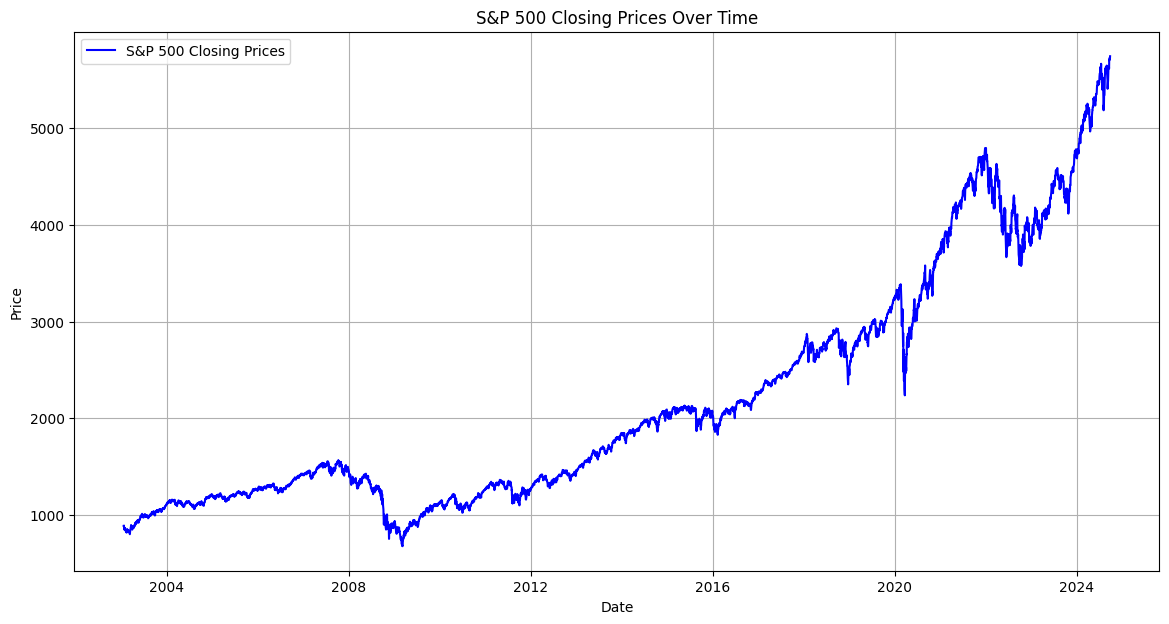

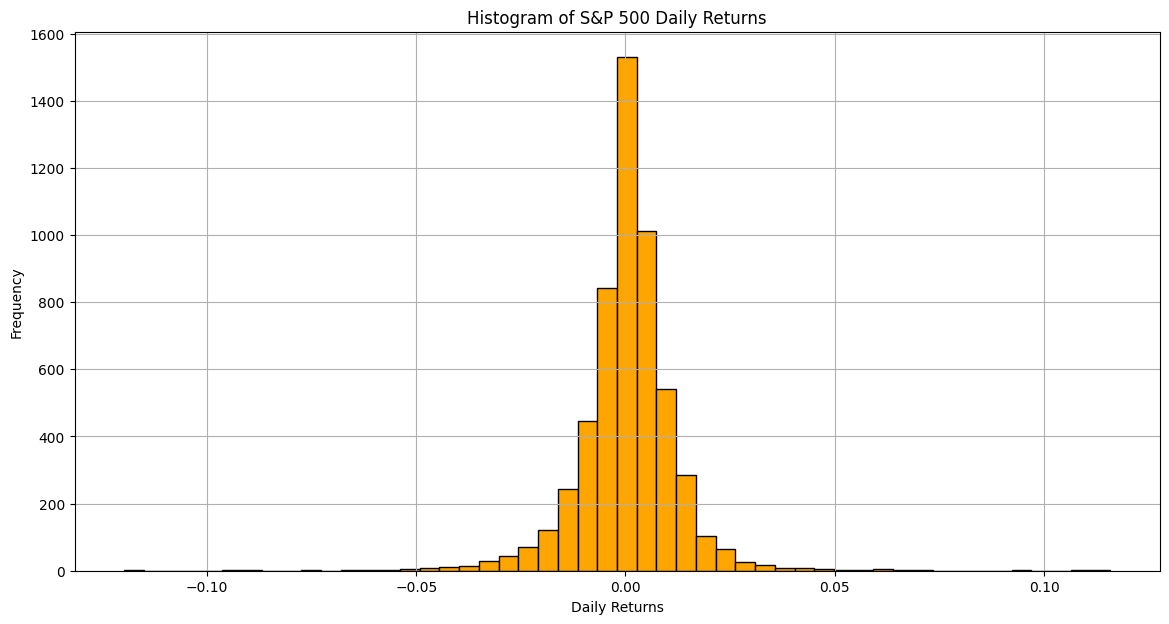

In [3]:
# 1. Plot the closing prices over time
plt.figure(figsize=(14, 7))
plt.plot(sp500['Close'], label='S&P 500 Closing Prices', color='blue')
plt.title('S&P 500 Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 2. Calculate daily returns
sp500['Daily Returns'] = sp500['Close'].pct_change()

# Plot histogram of daily returns
plt.figure(figsize=(14, 7))
plt.hist(sp500['Daily Returns'].dropna(), bins=50, color='orange', edgecolor='black')
plt.title('Histogram of S&P 500 Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


### Explanation

- **Closing Prices Plot**:
  - We plot the closing prices to visualize the trend of the S&P 500 index over time.
  - This helps identify significant market events, trends, and patterns.

- **Daily Returns**:
  - **`sp500['Daily Returns'] = sp500['Close'].pct_change()`**: Calculates the daily percentage change in closing prices.
  - The histogram shows the distribution of daily returns, providing insights into market volatility.


## 3. Feature Engineering

We will create additional features that could improve our model's predictive power. These include:

- **RSI (Relative Strength Index)**: Indicates overbought or oversold conditions.
- **MACD (Moving Average Convergence Divergence)**: Shows momentum and trend direction.
- **Moving Averages (50-day and 200-day)**: Highlight short-term and long-term trends.

In [4]:
# 1. Calculate the 14-day RSI
delta = sp500['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
sp500['RSI'] = 100 - (100 / (1 + rs))

# 2. Calculate the MACD and Signal Line
ema_12 = sp500['Close'].ewm(span=12, adjust=False).mean()
ema_26 = sp500['Close'].ewm(span=26, adjust=False).mean()
sp500['MACD'] = ema_12 - ema_26
sp500['Signal Line'] = sp500['MACD'].ewm(span=9, adjust=False).mean()

# 3. Calculate 50-day and 200-day Moving Averages
sp500['50_MA'] = sp500['Close'].rolling(window=50).mean()
sp500['200_MA'] = sp500['Close'].rolling(window=200).mean()

# Drop rows with NaN values resulting from calculations
sp500_cleaned = sp500.dropna()

# Display the first few rows to verify the new features
print(sp500_cleaned[['RSI', 'MACD', 'Signal Line', '50_MA', '200_MA']].head())


                  RSI      MACD  Signal Line        50_MA      200_MA
Date                                                                 
2003-11-03  55.971472  6.945931     6.146828  1027.125397  947.735699
2003-11-04  53.912924  7.128931     6.343248  1028.316196  948.563849
2003-11-05  51.073346  7.076198     6.489838  1029.417798  949.431100
2003-11-06  62.233874  7.452020     6.682275  1030.642999  950.284650
2003-11-07  55.609556  7.275440     6.800908  1031.650398  951.243699


### Explanation

- **RSI (Relative Strength Index)**:
  - Measures the magnitude of recent price changes to evaluate overbought or oversold conditions.
  - **Overbought (>70)**: May indicate a price decrease.
  - **Oversold (<30)**: May indicate a price increase.

- **MACD (Moving Average Convergence Divergence)**:
  - Shows the relationship between two moving averages of a stock’s price.
  - **MACD Line**: Difference between the 12-day and 26-day EMA.
  - **Signal Line**: 9-day EMA of the MACD line.

- **Moving Averages**:
  - **50-day MA**: Short-term trend indicator.
  - **200-day MA**: Long-term trend indicator.

- **Data Cleaning**:
  - We drop rows with NaN values resulting from the calculations to ensure our dataset is complete for modeling.


## 4. Model Training and Evaluation

We will train several machine learning models to predict whether the S&P 500 index will go up or down the next day. The models include:

- **HistGradientBoostingClassifier**
- **RandomForestClassifier**
- **LogisticRegression**
- **Support Vector Classifier (SVC)**

We will compare their performance using accuracy, precision, recall, and F1-score.


In [5]:
# Prepare the target variable
sp500_cleaned['Target'] = np.where(sp500_cleaned['Daily Returns'].shift(-1) > 0, 1, -1)

# Prepare features and target
features = ['RSI', 'MACD', 'Signal Line', '50_MA', '200_MA']
X = sp500_cleaned[features].values
y = sp500_cleaned['Target'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVC': SVC()
}

# Train and evaluate models
model_results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    model_results[name] = {
        'Accuracy': accuracy,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score']
    }

# Display results
results_df = pd.DataFrame(model_results).T
print("\nModel Performance Comparison:")
print(results_df)


Training HistGradientBoosting...
Training RandomForest...
Training LogisticRegression...
Training SVC...

Model Performance Comparison:
                      Accuracy  Precision    Recall  F1-Score
HistGradientBoosting  0.549430   0.544941  0.549430  0.537520
RandomForest          0.501901   0.496170  0.501901  0.495208
LogisticRegression    0.531369   0.517124  0.531369  0.391068
SVC                   0.531369   0.282353  0.531369  0.368759


### Explanation

- **Target Variable**:
  - We create a target variable `Target` where:
    - **1** indicates the price will go up the next day.
    - **-1** indicates the price will go down the next day.

- **Features and Labels**:
  - **Features (`X`)**: RSI, MACD, Signal Line, 50-day MA, 200-day MA.
  - **Labels (`y`)**: Target variable indicating price movement.

- **Model Initialization**:
  - We initialize four different classifiers to compare their performance.

- **Training and Evaluation**:
  - Each model is trained on the training set and evaluated on the test set.
  - We collect metrics like Accuracy, Precision, Recall, and F1-Score for comparison.

- **Results**:
  - The performance metrics are stored in a DataFrame for easy comparison.


## 5. Results and Analysis

We compare the performance of different models to determine which one predicts stock movements most effectively.



Final Model Comparison:
                      Accuracy  Precision    Recall  F1-Score
HistGradientBoosting  0.549430   0.544941  0.549430  0.537520
RandomForest          0.501901   0.496170  0.501901  0.495208
LogisticRegression    0.531369   0.517124  0.531369  0.391068
SVC                   0.531369   0.282353  0.531369  0.368759


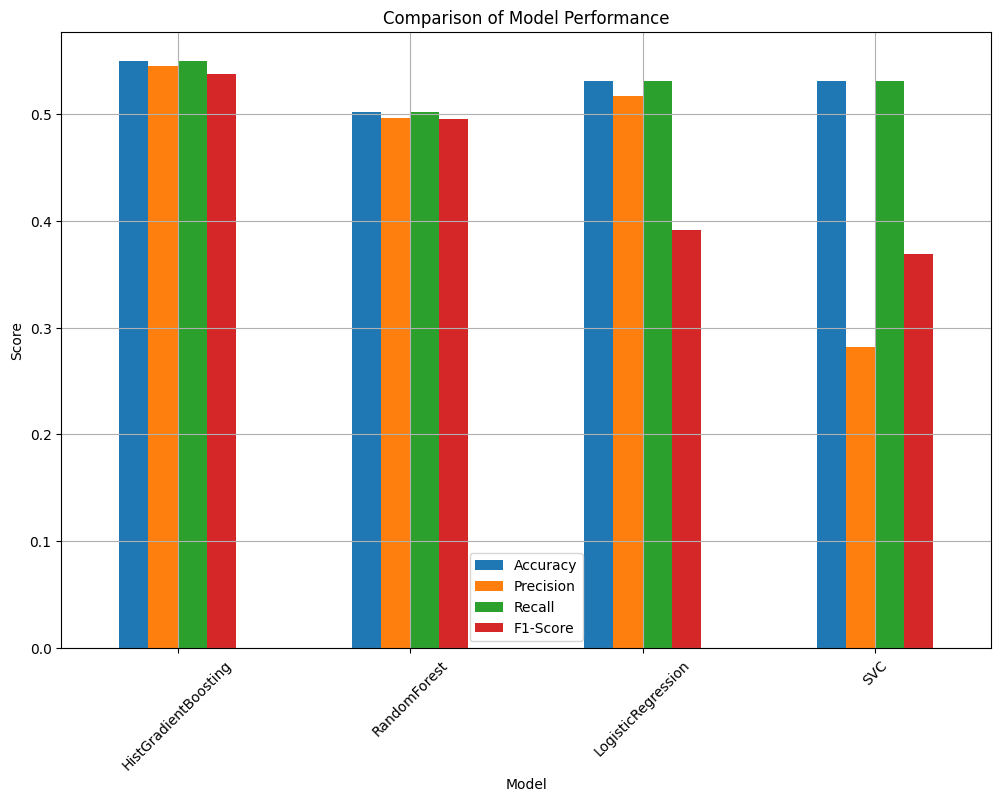

In [6]:
# Display the comparison of model performance
print("\nFinal Model Comparison:")
print(results_df)

# Plot the performance metrics
results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(kind='bar', figsize=(12, 8))
plt.title('Comparison of Model Performance')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


### Interpretation

- **Accuracy**: Indicates the percentage of correct predictions made by the model.
- **Precision**: Out of all positive predictions, how many were correct.
- **Recall**: Out of all actual positive cases, how many were correctly predicted.
- **F1-Score**: The harmonic mean of precision and recall, providing a balance between the two.

**Analysis**:

- **Model Comparison**:
  - Examine which model has the highest accuracy and F1-Score.
  - Consider the trade-offs between precision and recall for each model.
  
- **Insights**:
  - A model with slightly better than random accuracy (around 50%) indicates the challenge of predicting stock market movements.
  - Further improvements may require additional features or more sophisticated models.


## 6. Conclusion and Next Steps

**Conclusion**:

- Predicting stock market movements is challenging due to market volatility and the influence of numerous external factors.
- The models achieved accuracy slightly above random guessing, indicating limited predictive power with the current features.

**Next Steps**:

- **Feature Enhancement**:
  - Include additional technical indicators (e.g., Bollinger Bands, stochastic oscillators).
  - Incorporate fundamental data or macroeconomic indicators.

- **Advanced Modeling**:
  - Experiment with more sophisticated algorithms like XGBoost or neural networks.
  - Implement hyperparameter tuning to optimize model performance.

- **Data Expansion**:
  - Use a longer historical period to capture more market cycles.
  - Consider higher frequency data (e.g., hourly or minute-level) for more granularity.

**Final Thoughts**:

While this project provides a foundational approach to stock market prediction using machine learning, achieving high predictive accuracy remains complex. Continuous exploration and integration of diverse data sources and advanced modeling techniques are essential for improvement.


In [7]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune for RandomForest
param_grid = {
    'n_estimators': [100, 200, 300],     # Number of trees in the forest
    'max_depth': [5, 10, 15],            # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],     # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]        # Minimum number of samples required at a leaf node
}

# Initialize GridSearchCV with the RandomForest model and parameter grid
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model with the training data
grid_search.fit(X_train, y_train)

# Best hyperparameters found by GridSearchCV
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

# Calculate accuracy and classification report for the tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
report_tuned = classification_report(y_test, y_pred_tuned)

print(f"Tuned Model Accuracy: {accuracy_tuned:.4f}")
print("\nClassification Report for the Tuned Model:")
print(report_tuned)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END max_depth=5, min_samples_leaf